In [1]:
fidx = 'ens'
midx = '12'

# using results from versions of ens_oof.ipynb
mnames = ['iv3_a1','irv2_a1','se_resnext_a9','resnet34_46']
weights = [1./12,1./12,1./12,0.25]

mnames += ['iv3_a4','iv3_a5','resnet_a11','nas_a7','irv2_a6',
          'se_resnet_c18','se_resnet_b22','se_resnext_e11']
weights += [0.1,0.1,0.35,0.1,0.1,0.35,0.1,0.3]

mnames += ['blend_0459']
weights += [0.5]

threshold = 0.36
nfold = 20

sub_dir = './sub/'

print(fidx,midx,threshold,nfold)
for m,w in zip(mnames,weights):
    print(w,m)
import numpy as np
print('sum of weights',sum(np.array(weights)))
# assert(len(mnames)==len(weights))

ens 12 0.36 20
0.08333333333333333 iv3_a1
0.08333333333333333 irv2_a1
0.08333333333333333 se_resnext_a9
0.25 resnet34_46
0.1 iv3_a4
0.1 iv3_a5
0.35 resnet_a11
0.1 nas_a7
0.1 irv2_a6
0.35 se_resnet_c18
0.1 se_resnet_b22
0.3 se_resnext_e11
0.5 blend_0459
sum of weights 2.5


In [2]:
blist = ['blend_0459']
tlist = ['iv3_a4']
klist = ['resnet34_46','resnet50','resnet34']
print(tlist)
print(klist)

['iv3_a4']
['resnet34_46', 'resnet50', 'resnet34']


In [3]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit, expit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

/home/sasrdw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [5]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [6]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [7]:
test_df.columns

Index(['Predicted'], dtype='object')

In [8]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [9]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

firstm = True
sumw = 0.

for m in mnames:

    firstf = True
    if m in blist: suffix = '.npy'
    elif m in klist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['','a','b','c','d','e','f','g','h','i']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                navg = 1
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                navg += 1
    
    if navg == 0: print('Error: No files found')
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



./sub/iv3_a1_0_mm.pkl
2.0611537e-09 0.05761648 0.99999416
(11702, 28) 2.0611537e-09 0.05761648 0.99999416

./sub/iv3_a1_1_mm.pkl
2.0611537e-09 0.056957327 0.9999049
(11702, 28) 2.0611537e-09 0.056957327 0.9999049
[[1.    0.961]
 [0.961 1.   ]]

./sub/iv3_a1_2_mm.pkl
2.0611537e-09 0.05643581 0.9999939
(11702, 28) 2.0611537e-09 0.05643581 0.9999939
[[1.    0.971]
 [0.971 1.   ]]

./sub/iv3_a1_3_mm.pkl
2.0611537e-09 0.0572561 0.99998677
(11702, 28) 2.0611537e-09 0.0572561 0.99998677
[[1.    0.977]
 [0.977 1.   ]]

./sub/iv3_a1_4_mm.pkl
2.0611537e-09 0.056552935 0.9999939
(11702, 28) 2.0611537e-09 0.056552935 0.9999939
[[1.    0.976]
 [0.976 1.   ]]
iv3_a1 5 (11702, 28) 2.0611537e-09 0.05696372 0.9998721 0.05588788241326269

./sub/irv2_a1_0_mm.pkl
2.0611537e-09 0.0586627 0.9999999
(11702, 28) 2.0611537e-09 0.0586627 0.9999999

./sub/irv2_a1_1_mm.pkl
2.0611537e-09 0.05763268 1.0
(11702, 28) 2.0611537e-09 0.05763268 1.0
[[1.    0.964]
 [0.964 1.   ]]

./sub/irv2_a1_2_mm.pkl
2.0611537e-09 0.

In [10]:
test_df.columns

Index(['Predicted', 'iv3_a1', 'irv2_a1', 'se_resnext_a9', 'resnet34_46',
       'iv3_a4', 'iv3_a5', 'resnet_a11', 'nas_a7', 'irv2_a6', 'se_resnet_c18',
       'se_resnet_b22', 'se_resnext_e11', 'blend_0459'],
      dtype='object')

In [11]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [12]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])).flatten())
print(clist)
r = np.corrcoef(f)
print(r)

['iv3_a1', 'irv2_a1', 'se_resnext_a9', 'resnet34_46', 'iv3_a4', 'iv3_a5', 'resnet_a11', 'nas_a7', 'irv2_a6', 'se_resnet_c18', 'se_resnet_b22', 'se_resnext_e11', 'blend_0459']
[[1.    0.976 0.936 0.884 0.872 0.889 0.829 0.868 0.877 0.86  0.866 0.887 0.94 ]
 [0.976 1.    0.946 0.887 0.872 0.89  0.83  0.871 0.88  0.863 0.87  0.893 0.949]
 [0.936 0.946 1.    0.874 0.852 0.866 0.812 0.865 0.864 0.862 0.866 0.89  0.928]
 [0.884 0.887 0.874 1.    0.828 0.845 0.906 0.804 0.832 0.825 0.81  0.836 0.882]
 [0.872 0.872 0.852 0.828 1.    0.885 0.819 0.846 0.86  0.836 0.821 0.873 0.878]
 [0.889 0.89  0.866 0.845 0.885 1.    0.823 0.887 0.915 0.883 0.857 0.87  0.886]
 [0.829 0.83  0.812 0.906 0.819 0.823 1.    0.775 0.81  0.802 0.775 0.814 0.824]
 [0.868 0.871 0.865 0.804 0.846 0.887 0.775 1.    0.884 0.891 0.887 0.867 0.88 ]
 [0.877 0.88  0.864 0.832 0.86  0.915 0.81  0.884 1.    0.881 0.862 0.869 0.88 ]
 [0.86  0.863 0.862 0.825 0.836 0.883 0.802 0.891 0.881 1.    0.926 0.865 0.869]
 [0.866 0.87  0

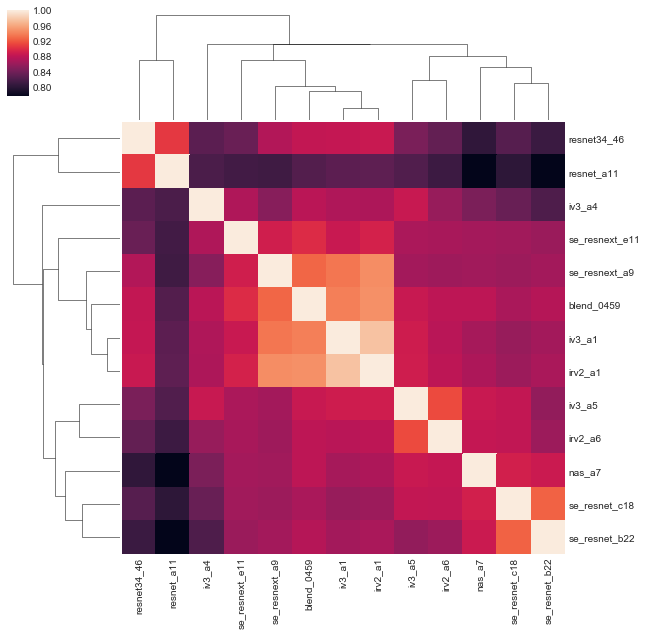

In [13]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [14]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 13)
flat.csv


In [15]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])))
m = np.array(f)
print(m.shape)

(13, 11702, 28)


In [16]:
weights = np.array(weights)
print(weights)

[0.083 0.083 0.083 0.25  0.1   0.1   0.35  0.1   0.1   0.35  0.1   0.3   0.5  ]


In [17]:
ens = np.average(m,axis=0,weights=weights)
print(ens.shape)

(11702, 28)


In [18]:
print(ens[1])

[0.09  0.015 0.038 0.107 0.025 0.781 0.098 0.026 0.007 0.003 0.003 0.07  0.029 0.019 0.026 0.009
 0.027 0.013 0.065 0.045 0.009 0.044 0.023 0.067 0.078 0.298 0.027 0.005]


In [19]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [20]:
# desired class proportions from lb probing
eps = 0.01
desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : eps,
9 : eps,
10 : eps,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : eps,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : eps,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : eps,
25 : 0.222493888,
26 : 0.028806584,
27 : eps
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.01, 9: 0.01, 10: 0.01, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.01, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.01, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.01, 25: 0.222493888, 26: 0.028806584, 27: 0.01}


In [21]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0.36
0 0.3624 0.4722 Nucleoplasm
1 0.0438 0.0358 Nuclear membrane
2 0.0753 0.0946 Nucleoli
3 0.0593 0.0274 Nucleoli fibrillar center
4 0.0753 0.0341 Nuclear speckles
5 0.0753 0.0473 Nuclear bodies
6 0.0438 0.0194 Endoplasmic reticulum
7 0.0753 0.0656 Golgi apparatus
8 0.0100 0.0003 Peroxisomes
9 0.0100 0.0003 Endosomes
10 0.0100 0.0002 Lysosomes
11 0.0438 0.0291 Intermediate filaments
12 0.0438 0.0173 Actin filaments
13 0.0142 0.0109 Focal adhesion sites
14 0.0438 0.0435 Microtubules
15 0.0100 0.0000 Microtubule ends
16 0.0288 0.0119 Cytokinetic bridge
17 0.0142 0.0109 Mitotic spindle
18 0.0288 0.0228 Microtubule organizing center
19 0.0593 0.0356 Centrosome
20 0.0100 0.0017 Lipid droplets
21 0.1261 0.1672 Plasma membrane
22 0.0288 0.0183 Cell junctions
23 0.0753 0.0778 Mitochondria
24 0.0100 0.0091 Aggresome
25 0.2225 0.3454 Cytosol
26 0.0288 0.0080 Cytoplasmic bodies
27 0.0100 0.0000 Rods & rings


In [22]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [0.636 0.6   0.63  0.581 0.575 0.59  0.587 0.6   0.594 0.594 0.593 0.594 0.581 0.614 0.612 0.593
 0.595 0.61  0.604 0.59  0.599 0.62  0.598 0.61  0.621 0.628 0.584 0.593]
Fractions:  [0.369 0.034 0.071 0.031 0.038 0.047 0.02  0.059 0.    0.    0.    0.028 0.019 0.009 0.038 0.
 0.011 0.006 0.017 0.036 0.001 0.114 0.016 0.064 0.007 0.211 0.009 0.   ]
Fractions (th = 0.5):  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
# custom thresholds to match lb proportions
thresholds = np.linspace(0.9, 0.1, 100001)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 0.5691 0.3624 0.3625 Nucleoplasm
1 0.2323 0.0438 0.0439 Nuclear membrane
2 0.4917 0.0753 0.0753 Nucleoli
3 0.1526 0.0593 0.0595 Nucleoli fibrillar center
4 0.1239 0.0753 0.0753 Nuclear speckles
5 0.2455 0.0753 0.0753 Nuclear bodies
6 0.1847 0.0438 0.0439 Endoplasmic reticulum
7 0.3070 0.0753 0.0753 Golgi apparatus
8 0.1000 0.0100 0.0019 Peroxisomes
9 0.1000 0.0100 0.0019 Endosomes
10 0.1000 0.0100 0.0008 Lysosomes
11 0.2159 0.0438 0.0439 Intermediate filaments
12 0.1292 0.0438 0.0439 Actin filaments
13 0.2747 0.0142 0.0143 Focal adhesion sites
14 0.3528 0.0438 0.0439 Microtubules
15 0.1000 0.0100 0.0009 Microtubule ends
16 0.2203 0.0288 0.0289 Cytokinetic bridge
17 0.3195 0.0142 0.0143 Mitotic spindle
18 0.3095 0.0288 0.0289 Microtubule organizing center
19 0.2227 0.0593 0.0594 Centrosome
20 0.1192 0.0100 0.0101 Lipid droplets
21 0.4521 0.1261 0.1261 Plasma membrane
22 0.2270 0.0288 0.0289 Cell junctions
23 0.3772 0.0753 0.0753 Mitochondria
24 0.3070 0.0100 0.0101 Aggresome
25 0.5090

In [24]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [25]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.595881045975047 5.0


In [26]:
print(sum(xps==0)/pred.shape[0])

0.051016920184583835


In [27]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 0 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 12 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '5', '0 5 25', '0', '', '4', '4 25',

In [28]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/ens12.csv


In [29]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4242 prop 0.3625
1 Nuclear membrane count 514 prop 0.0439
2 Nucleoli count 881 prop 0.0753
3 Nucleoli fibrillar center count 696 prop 0.0595
4 Nuclear speckles count 881 prop 0.0753
5 Nuclear bodies count 881 prop 0.0753
6 Endoplasmic reticulum count 514 prop 0.0439
7 Golgi apparatus count 881 prop 0.0753
8 Peroxisomes count 22 prop 0.0019
9 Endosomes count 22 prop 0.0019
10 Lysosomes count 9 prop 0.0008
11 Intermediate filaments count 514 prop 0.0439
12 Actin filaments count 514 prop 0.0439
13 Focal adhesion sites count 167 prop 0.0143
14 Microtubules count 514 prop 0.0439
15 Microtubule ends count 11 prop 0.0009
16 Cytokinetic bridge count 338 prop 0.0289
17 Mitotic spindle count 167 prop 0.0143
18 Microtubule organizing center count 338 prop 0.0289
19 Centrosome count 695 prop 0.0594
20 Lipid droplets count 118 prop 0.0101
21 Plasma membrane count 1476 prop 0.1261
22 Cell junctions count 338 prop 0.0289
23 Mitochondria count 881 prop 0.0753
24 Aggresome count 118

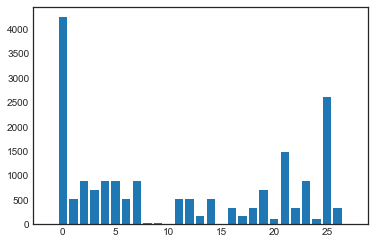

In [30]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [31]:
from sklearn.metrics import f1_score

# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [32]:
f1_sub(fname,'sub/protein_classification.csv')

0.6598666931743741

In [33]:
f1_sub(fname,'sub/submit_InceptionV3.csv')

0.6229649131672799

In [34]:
f1_sub(fname,'sub/submit_InceptionResNetV2_3.csv')

0.5991112413829541

In [35]:
f1_sub(fname,'sub/blend_InceptionV3_InceptionResNetV2_DenseNet201_2.csv')

0.6993387117531541

In [36]:
f1_sub(fname,'sub/iv3_0.csv')

0.641545890476597

In [37]:
f1_sub(fname,'sub/irv2_0.csv')

0.6597500414493661

In [38]:
f1_sub(fname,'sub/resnet34_0.csv')

0.6868470680105965

In [39]:
f1_sub(fname,'sub/resnet50_0.csv')

0.682455588371268

In [40]:
f1_sub(fname,'sub/resnet4.csv')

0.7133553923461321

In [41]:
f1_sub(fname,'sub/resnet5.csv')

0.6500405467701886

In [42]:
f1_sub(fname,'sub/resnet6.csv')

0.7247362241078521

In [43]:
f1_sub(fname,'sub/resnet7.csv')

0.6796773935258269

In [44]:
f1_sub(fname,'sub/se_resnet1.csv')

0.7163198417517105

In [45]:
f1_sub(fname,'sub/se_resnet2.csv')

0.7195327129227779

In [46]:
f1_sub(fname,'sub/se_resnext6.csv')

0.6518124455585401

In [47]:
f1_sub(fname,'sub/se_resnext9.csv')

0.6948999001081603

In [48]:
f1_sub(fname,'sub/ens0.csv')

0.706052769706676

In [49]:
f1_sub(fname,'sub/ens1.csv')

0.7132028276446096

In [50]:
f1_sub(fname,'sub/ens2.csv')

0.7064446317199259

In [51]:
f1_sub(fname,'sub/ens6.csv')

0.7650177794506254

In [52]:
f1_sub(fname,'sub/ens7.csv')

0.7321793512403241

In [53]:
f1_sub(fname,'sub/ens8.csv')

0.8707024144377097

In [54]:
f1_sub(fname,'sub/ens9.csv')

0.828632533710829

In [55]:
f1_sub(fname,'sub/ens10.csv')

0.9418377926542165

In [56]:
f1_sub(fname,'sub/ens11.csv')

0.9666223945300703

In [57]:
print(fname)

sub/ens12.csv
